## Optimizing Training Pipeline in Pytorch

To improve training performance in any deep learning pipeline, pytorch suggests few extra additions of codes in exitin pipeline.
These additions are explained and mentioned well here in [Performance Tuning Guide](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html) . In this notebook you will encounter few of such features with hands-on dedicated for GPU Computing.

In [1]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

### Set GPU Device if multiple

In [3]:
!nvidia-smi

Tue May 17 11:14:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 26%   60C    P2    91W / 250W |   2999MiB / 11178MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   

In [4]:
class Config():
    base_path = "../../../dataset/pediatric_dataset/physionet.org/files/vindr-pcxr/1.0.0/"
    train_path = base_path + "train/"
    test_path = base_path + "test/"
    train_csv_path = base_path + "annotations_train.csv"
    test_csv_path = base_path + "annotations_test.csv"
    image_size = (224,224)
    BATCH_SIZE = 32
    pin_memory = True
    num_workers = 3
    lr=0.001
    EPOCHS=30
    gpu_id=1
    device = torch.device(f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu')
    val_split = 0.1
    SEED=42
    return_logs=False
    load = False
    model_name = "shufflenet"
    roc_title = f'roc_{model_name}'
    checkpoint = f"../saved_models/{model_name}_checkpoint.pt"
    saved_path = f'../saved_models/{model_name}_v1.pt'
    loss_acc_path = f'../loss_acc_roc/loss-acc-{model_name}.svg'
    roc_path = f'../loss_acc_roc/roc-{model_name}.svg'
    fta_path = f'../roc_pickle_files/fta_{model_name}.pkl'

config = Config()

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
print(config.device)

random.seed(config.SEED)
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)
torch.cuda.manual_seed(config.SEED)
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


class PCXRDataset():
    def __init__(self,csv_file,dir_path):
        self.dir_path = dir_path
        csv_ = pd.read_csv(csv_file)

        csv_ = csv_.drop_duplicates(subset=['image_id'])
        csv_.class_name = csv_.class_name.apply(lambda x:1 if x=='No finding' else 0)
        csv_ = np.array(csv_.loc[:,['image_id','class_name']])
        self.images = csv_

        self.transformations = torchvision.transforms.Compose([
            torchvision.transforms.Resize(config.image_size),
            torchvision.transforms.ToTensor()
        ])
            
    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_id, label = self.images[idx]
        img_path = os.path.join(self.dir_path,f'{img_id}.dicom')
        ds = pydicom.dcmread(img_path)
        new_img = ds.pixel_array.astype('float')
        new_img = np.maximum(new_img,0) / new_img.max()
        new_img = (new_img * 255).astype(np.uint8)
        final_img = Image.fromarray(new_img)
        final_img = final_img.convert('RGB')
        final_img = self.transformations(final_img)
        return final_img, label

def GetDataloader():
    train_data = PCXRDataset(config.train_csv_path,config.train_path)
    test_data = PCXRDataset(config.test_csv_path,config.test_path)
    total_len = len(train_data)
    val_len = int(config.val_split * total_len)
    train_len = total_len - val_len
    training_data,val_data = torch.utils.data.dataset.random_split(train_data,[train_len,val_len])

    train_loader = torch.utils.data.DataLoader(
        training_data,
        shuffle=True,
        batch_size=config.BATCH_SIZE,
        pin_memory = config.pin_memory,
        num_workers = config.num_workers
        )
    
    val_loader = torch.utils.data.DataLoader(
        val_data,
        shuffle=True,
        batch_size=config.BATCH_SIZE,
        pin_memory = config.pin_memory,
        num_workers = config.num_workers
        )

    test_loader = torch.utils.data.DataLoader(
        test_data,
        shuffle=True,
        batch_size=config.BATCH_SIZE,
        pin_memory = config.pin_memory,
        num_workers = config.num_workers
        )

    return train_loader, test_loader, val_loader, training_data, test_data, val_data
train_dl,test_dl,valid_dl, train_data,test_data, valid_data = GetDataloader()
criterion = nn.CrossEntropyLoss()

cuda:1


In [5]:
##############################################################
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="1"
##############################################################

### Use device for `cuda` or `cpu` based on availability

In [6]:
####################################################################
#GPU using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
####################################################################

device(type='cuda')

In [7]:
config = dict(
    saved_path="saved/random.pt",
    best_saved_path = "saved/random_best.pt",
    lr=0.001, 
    EPOCHS = 3,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 224,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False)

tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 0, 1])


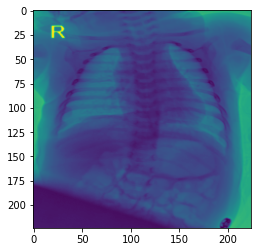

In [8]:
import matplotlib.pyplot as plt
a = iter(valid_dl)
b = next(a)
print(b[1])
plt.imshow(b[0][0][0])

In [9]:
def evaluation(model,test_dl):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    preds = []
    pred_labels = []
    labels = []

            # Disable gradient calculation for validation or inference using torch.no_rad()
    with torch.no_grad():
                for x,y in test_dl:
                    x = x.to(config['device'])
                    y = y.to(config['device']) #CHW --> #HWC
                    valid_logits = model(x)
                    predict_prob = F.softmax(valid_logits)
                    _,predictions = predict_prob.max(1)
                    predictions = predictions.to('cpu')

                    _, valid_preds = torch.max(valid_logits, 1)
                    valid_loss = criterion(valid_logits,y)
                    running_loss += valid_loss.item() * x.size(0)
                    running_corrects += torch.sum(valid_preds == y.data)
                    total += y.size(0)
                    predict_prob = predict_prob.to('cpu')

                    pred_labels.extend(list(predictions.numpy()))
                    preds.extend(list(predict_prob.numpy()))
                    y = y.to('cpu')
                    labels.extend(list(y.numpy()))

    epoch_loss = running_loss / len(test_data)
    epoch_acc = running_corrects.double() / len(test_data)
    print("Test Loss is {}".format(epoch_loss))
    print("Test Accuracy is {}".format(epoch_acc.cpu()))
    return np.array(labels),np.array(pred_labels),np.array(preds)

In [10]:
criterion = nn.CrossEntropyLoss()

Load Model : Pretrained from torchvision model zoo or Saved model

In [11]:
efficientnet = models.efficientnet_b4(pretrained = True)
efficientnet.classifier[1] = nn.Linear(in_features = 1792, out_features = 2, bias = True)
model = efficientnet

In [12]:
model.load_state_dict(torch.load('saved/efficientnet_b4.pt'))
model = model.to(config['device'])
optimizer = optim.Adam(model.parameters(),lr=config['lr'])

### Efficientnet

In [13]:
labels, pred_labels, preds = evaluation(model,test_dl)

Test Loss is 2.015545713107929
Test Accuracy is 0.5869720830350751


In [14]:
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
cm = metrics.confusion_matrix(labels,pred_labels)
print('\n classwise accuracy')
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm.diagonal())

print(roc_auc_score(1-np.array(labels), np.array(preds)[:,0]))
pred_effb4_1 = np.array(preds[:,0])
y_test_effb4_1 = 1-np.array(labels)

              precision    recall  f1-score   support

    abnormal       0.30      0.13      0.18       490
      normal       0.64      0.83      0.72       907

    accuracy                           0.59      1397
   macro avg       0.47      0.48      0.45      1397
weighted avg       0.52      0.59      0.53      1397


 classwise accuracy
[0.13061224 0.83351709]
0.45008437774227666


In [15]:
#y_pred = np.transpose([pred[:, 1] for pred in preds])
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.4500933780347861

In [24]:
pred_effb4_1 = preds[:,1]
y_test_effb4_1 = np.array(labels)

## Mobilenet v2

In [35]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(in_features = 1280, out_features = 2, bias = True)
model = mobilenet
model.load_state_dict(torch.load('saved/mobilenetv2.pt'))
model = model.to(config['device'])

In [36]:
labels, pred_labels, preds = evaluation(model,test_dl)
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))

Test Loss is 1.1872169836640956
Test Accuracy is 0.6320687186828919
              precision    recall  f1-score   support

    abnormal       0.36      0.06      0.10       490
      normal       0.65      0.94      0.77       907

    accuracy                           0.63      1397
   macro avg       0.50      0.50      0.44      1397
weighted avg       0.55      0.63      0.54      1397



In [18]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.48337870980806874

In [28]:
pred_mobv2_1 = np.array(preds[:,1])
y_test_mobv2_1 = np.array(labels)

## Mobilenet v3

In [37]:
mobilenet = models.mobilenet_v3_small(pretrained=True)
mobilenet.classifier[3] = nn.Linear(in_features = 1024, out_features = 2, bias = True)
model = mobilenet
model.load_state_dict(torch.load('saved/mobilenetv3.pt'))
model = model.to(config['device'])

In [38]:
labels, pred_labels, preds = evaluation(model,test_dl)
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

Test Loss is 1.326555797519561
Test Accuracy is 0.5318539727988547
              precision    recall  f1-score   support

    abnormal       0.37      0.50      0.43       490
      normal       0.67      0.55      0.60       907

    accuracy                           0.53      1397
   macro avg       0.52      0.52      0.52      1397
weighted avg       0.57      0.53      0.54      1397



(0.6702557200538358, 0.5490628445424476, 0.6036363636363636, None)

In [21]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.5217469567760952

In [33]:
pred_mobv3_1 = np.array(preds[:,1])
y_test_mobv3_1 = np.array(labels)

## Shufflenet

In [39]:
shufflenet = models.shufflenet_v2_x1_0(pretrained = True)
shufflenet.fc = nn.Linear(in_features = 1024, out_features = 2, bias=True)
model = shufflenet

In [40]:
model.load_state_dict(torch.load('saved/shufflenetv1.pth'))
model = model.to(config['device'])

In [41]:
labels, pred_labels, preds = evaluation(model,test_dl)
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

Test Loss is 1.282204329540837
Test Accuracy is 0.6005726556907659
              precision    recall  f1-score   support

    abnormal       0.34      0.15      0.21       490
      normal       0.65      0.84      0.73       907

    accuracy                           0.60      1397
   macro avg       0.50      0.50      0.47      1397
weighted avg       0.54      0.60      0.55      1397



(0.6480067854113656, 0.8423373759647188, 0.7325023969319271, None)

In [25]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.4875278446549513

In [45]:
pred_shuff_1 = np.array(preds[:,1])
y_test_shuff_1 = np.array(labels)

## ResNet50

In [42]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features = 2048, out_features = 2, bias = True))
model = resnet50

model.load_state_dict(torch.load('saved/resnet50.pt'))
model = model.to(config['device'])

In [43]:
labels, pred_labels, preds = evaluation(model,test_dl)
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

Test Loss is 1.3891786077488466
Test Accuracy is 0.5934144595561918
              precision    recall  f1-score   support

    abnormal       0.36      0.20      0.26       490
      normal       0.65      0.81      0.72       907

    accuracy                           0.59      1397
   macro avg       0.50      0.50      0.49      1397
weighted avg       0.55      0.59      0.56      1397



(0.6509349955476402, 0.8059536934950385, 0.7201970443349754, None)

In [28]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.5080676371982089

In [69]:
pred_res50 = np.array(preds)
y_test_res50 = np.array(labels)

## Squeezenet

In [44]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
squeezenet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model = squeezenet
model.load_state_dict(torch.load('saved/squeezenet.pt'))
model = model.to(config['device'])

In [45]:
labels, pred_labels, preds = evaluation(model,test_dl)
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

Test Loss is 0.6967785880662922
Test Accuracy is 0.49749463135289906
              precision    recall  f1-score   support

    abnormal       0.34      0.47      0.40       490
      normal       0.64      0.51      0.57       907

    accuracy                           0.50      1397
   macro avg       0.49      0.49      0.48      1397
weighted avg       0.54      0.50      0.51      1397



(0.6413793103448275, 0.5126791620727673, 0.5698529411764706, None)

In [31]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.4627432891568976

In [74]:
y_test = np.array(labels)
pred_squeeze = np.array(preds)

# ExLNet

In [46]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Sequential(
    nn.BatchNorm2d(16),
    nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16))

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Sequential(nn.BatchNorm2d(16),
                                                 nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)
                                                )
squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Sequential(nn.BatchNorm2d(32),
                                                 nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32))

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Sequential(nn.BatchNorm2d(32),
                                                 nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32))

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Sequential(nn.BatchNorm2d(48),
                                                 nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48))

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier = nn.Sequential(
                                        nn.Dropout(0.5),
                                        nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1)),
                                        nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

model = squeezenet

In [47]:
model.load_state_dict(torch.load('saved/exlbn1_best.pt'))
model = model.to(config['device'])
labels, pred_labels, preds = evaluation(model,test_dl)
print(metrics.classification_report(labels,pred_labels,target_names = ['abnormal','normal']))
precision_recall_fscore_support(np.array(labels), np.array(pred_labels), average='binary')

Test Loss is 0.6690830521781528
Test Accuracy is 0.6249105225483178
              precision    recall  f1-score   support

    abnormal       0.41      0.15      0.22       490
      normal       0.66      0.88      0.75       907

    accuracy                           0.62      1397
   macro avg       0.53      0.52      0.49      1397
weighted avg       0.57      0.62      0.57      1397



(0.6578730420445177, 0.8798235942668137, 0.7528301886792452, None)

In [34]:
roc_auc_score(np.array(labels), np.array(preds)[:,1])

0.5155435051639178